[216  94]
(256, 256, 1)
(256, 256, 4)
image shape:  (256, 256, 3)
heatmap shape:  (256, 256, 1)


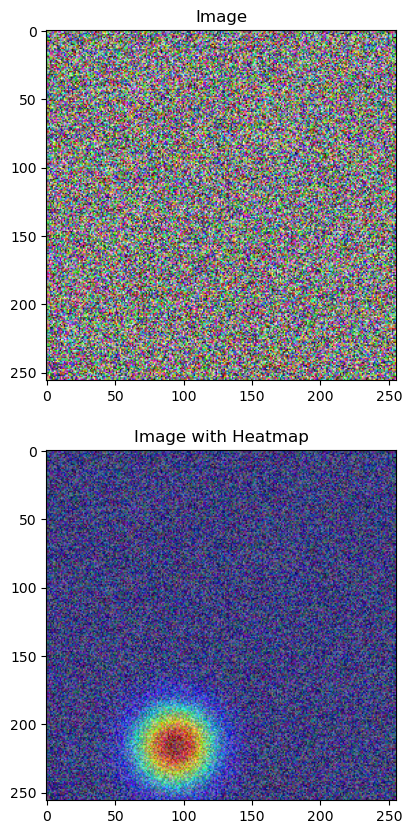

In [12]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from point_segmentation import random_point, create_gaussian_heatmap
#crete random image of size 256x256x3
img = np.random.rand(256, 256, 3)
reshape = (256, 256, 1)

mask = tf.concat([tf.ones((reshape[0], reshape[1] // 2)), tf.zeros((reshape[0], reshape[1] - reshape[0] // 2))], axis=1)
#plt.imshow(mask)
mask_pos = tf.where(mask == 1)

shuffled_indices = tf.random.shuffle(mask_pos)
x = shuffled_indices[0]
print(x.numpy())

h = create_gaussian_heatmap(mask_size=reshape, point=x, sigma=20)
print(h.shape)
#plt.imshow(h)

#concatenate image and heatmap along the channel axis
img = np.concatenate([img, h], axis=-1)
print(img.shape)
image = img[:, :, :3]
heatmap = np.expand_dims(img[:, :, 3], axis=-1)
print("image shape: ", image.shape)
print("heatmap shape: ", heatmap.shape)
plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.imshow(image)
plt.title("Image")

plt.subplot(2, 1, 2)
plt.imshow(image)
plt.imshow(heatmap, cmap='jet', alpha=0.5)
plt.title("Image with Heatmap")

plt.show()


In [ ]:
from data_loading import OxfordPetDataset
from augmentation import batch
from models import clip_segmentation_model # 2_c exercise
from experiment import plot_results

# Load the data
dataset = OxfordPetDataset()
dataset.load_data()
dataset.one_hot_encoding()

# Resize and normalize
reshape_size = (256, 256)
dataset.res_norm(reshape_size)
dataset.mask_prep()

train = dataset.train_raw
val = dataset.val_raw
test = dataset.test_raw
ds_info = dataset.ds_info
get_label_name = dataset.get_label_name

print("\n")

for i, example in enumerate(train.take(2)):  # Take two examples
    print(f"Example {i+1} - Image shape:", example['image'].shape)
    image = example['image']
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, i+1)
    plt.imshow(image)
    label = example['label']
    print(f"Example {i+1} - Label = ", label.numpy())
    mask = example['segmentation_mask']  # This is the segmentation mask
    plt.imshow(mask, cmap='gray', alpha=0.5)
    print(f"Example {i+1} - Mask shape:", mask.numpy().shape)
    print("\n")
plt.show()

Number of classes: 37
Number of training samples: 3312
Number of validation samples: 368
Number of test samples: 3669


2025-03-09 17:00:03.351243: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 851968 bytes after encountering the first element of size 851968 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


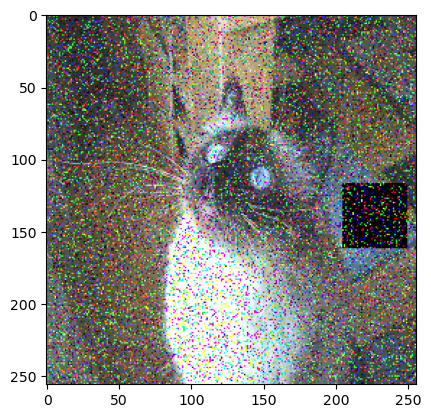

In [ ]:
import tensorflow as tf
from data_loading import OxfordPetDataset
import matplotlib.pyplot as plt

# Load the data
dataset = OxfordPetDataset()
dataset.load_data()
reshape_size = (256, 256)
dataset.res_norm(reshape_size)
dataset.mask_prep()

#dataset.first_perturb(std=18) #Gaussian pixel noise
#dataset.second_perturb(n=9) #Gaussian blurring
#dataset.third_perturb(a=1.25) #Image contrast increase/decrease
#dataset.fourth_perturb(b=45) #Image brightness increase/decrease
#dataset.fifth_perturb(p=45) #Occlusion of Image increase
#dataset.sixth_perturb(d=0.18) #Salt and pepper noise


test = dataset.test_raw

for i, example in enumerate(test.take(1)):
    image = example['image']
    plt.imshow(image)


    